# Traffic Sign Detection 

In [1]:
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image
import pandas as pd
import random



## Load in Dataset / Preprocessing

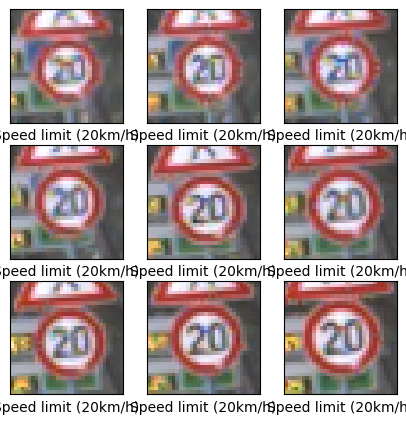

In [ ]:
data = []
labels = []
classes = 43
cur_path = os.getcwd()

# Retrieving training images and their labels 
for i in range(classes):
    path = os.path.join('dataset/','Train',str(i))
    images = os.listdir(path)

    for current in images:
        try:
            image = Image.open(path + '/'+ current)
            image = image.resize((32,32))
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")

# Converting lists into numpy arrays
data = np.array(data) / 255
labels = np.array(labels)

# Load in class names
classes = pd.read_csv('dataset/ClassNames.csv')
class_names = classes["SignName"].values

plt.figure(figsize=(5, 5))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(data[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[labels[i]])
plt.show()

## Visualise the dataset

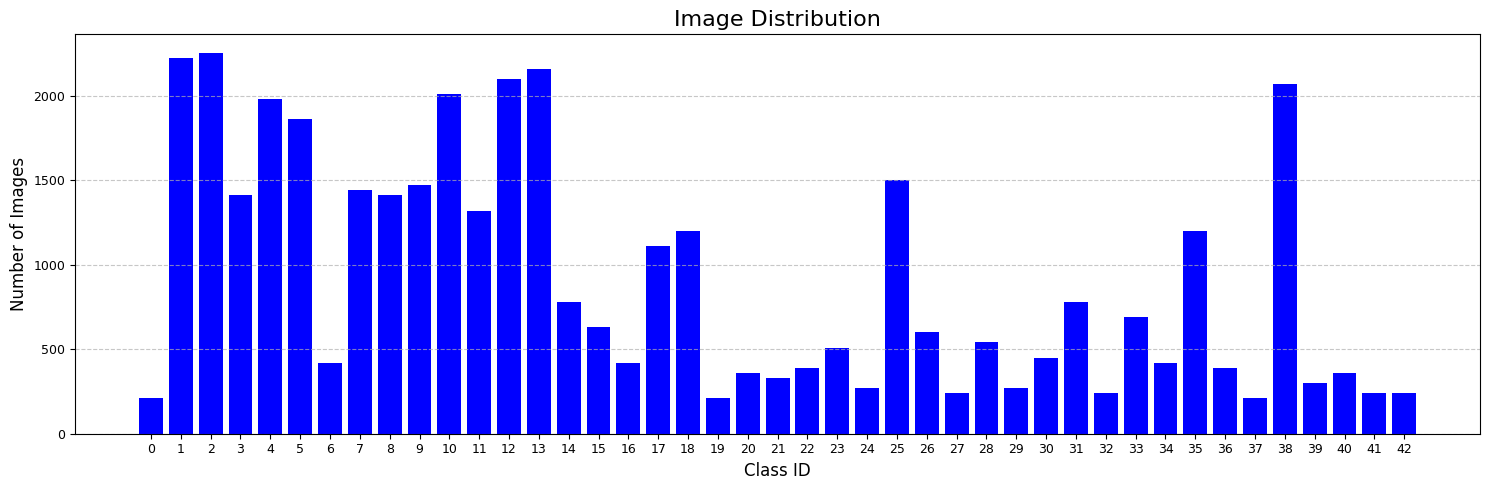

In [15]:
#Read in values from csv file
data = pd.read_csv('dataset/Train.csv')

class_counts = data['ClassId'].value_counts().sort_index()

class_ids = class_counts.index
counts = class_counts.values

plt.figure(figsize=(15, 5))
plt.bar(class_ids, counts, color='blue')

plt.title("Image Distribution", fontsize=16)
plt.xlabel("Class ID", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)

plt.xticks(ticks=class_ids, fontsize=9)
plt.yticks(fontsize=9)

plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

## Split data into training and testing sets

In [6]:
print(data.shape, labels.shape)

shuffle_indexes = np.arange(data.shape[0])
np.random.shuffle(shuffle_indexes)
data = data[shuffle_indexes]
labels = labels[shuffle_indexes]

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=15)


y_train = tf.keras.utils.to_categorical(y_train, 43)
y_test = tf.keras.utils.to_categorical(y_test, 43)

(39209, 32, 32, 3) (39209,)


### Load in test dataset for later evaluation

In [15]:
test_dataset = pd.read_csv('dataset/Test.csv')

test_labels = test_dataset["ClassId"].values
test_images = test_dataset["Path"].values

test_data=[]

# Retreiving the images
with tf.device('/GPU:0'):
    for image in test_images:
        current_image = cv2.imread('dataset/'+image)
        current_image = Image.fromarray(current_image, 'RGB')
        current_image = current_image.resize([32,32])
        test_data.append(np.array(current_image))

x_test_images=np.array(test_data) / 255



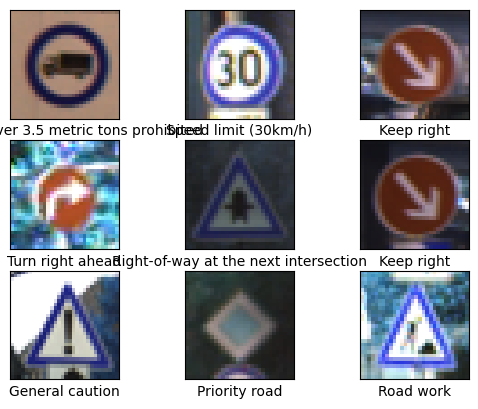

In [8]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[test_labels[i]])
plt.show()

## Data Augmentation

In [ ]:
data_generator = ImageDataGenerator(width_shift_range=0.1,
                                     height_shift_range=0.1, 
                                     rotation_range=10, 
                                     zoom_range=0.15, 
                                     fill_mode='nearest', 
                                     shear_range=0.15,
                                     horizontal_flip=False,
                                     vertical_flip =False)
data_generator.flow(x_train, y_train, batch_size=32)

## Create Model

In [16]:
def create_model():

    model = models.Sequential()

    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=x_train.shape[1:]))
    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(43, activation='softmax'))


    return model


In [33]:
model = create_model()

model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_64 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │       819,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 907,723 (3.46 MB)

 Trainable params: 907,531 (3.46 MB)

 Non-trainable params: 192 (768.00 B)

# Compile model and train

In [41]:
epochs = 30

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))


Epoch 1/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.6677 - loss: 1.3634 - val_accuracy: 0.9829 - val_loss: 0.0620
Epoch 2/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9748 - loss: 0.0891 - val_accuracy: 0.9912 - val_loss: 0.0314
Epoch 3/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9845 - loss: 0.0529 - val_accuracy: 0.9823 - val_loss: 0.0620
Epoch 4/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9818 - loss: 0.0650 - val_accuracy: 0.9799 - val_loss: 0.0892
Epoch 5/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9892 - loss: 0.0459 - val_accuracy: 0.9895 - val_loss: 0.0722
Epoch 6/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9892 - loss: 0.0445 - val_accuracy: 0.9923 - val_loss: 0.0438
Epoch 7/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9922 - loss: 0.0312 - val_accuracy: 0.9894 - val_loss: 0.0480
Epoch 8/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9915 - loss: 0.0359 - 

## Evaluate Performance

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Test Accuracy : 94.01%
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        60
           1       0.93      0.99      0.96       720
           2       0.99      0.99      0.99       750
           3       0.94      0.98      0.96       450
           4       0.99      0.98      0.99       660
           5       0.95      0.99      0.97       630
           6       0.97      0.86      0.91       150
           7       0.99      0.99      0.99       450
           8       0.96      0.99      0.97       450
           9       0.95      1.00      0.98       480
          10       1.00      0.99      0.99       660
          11       0.90      0.98      0.94       420
          12       0.92      0.90      0.91       690
          13       0.94      1.00      0.97       720
          14       1.00      0.84      0.91       270
          15       0.99      0.98      0.98       210
          16     

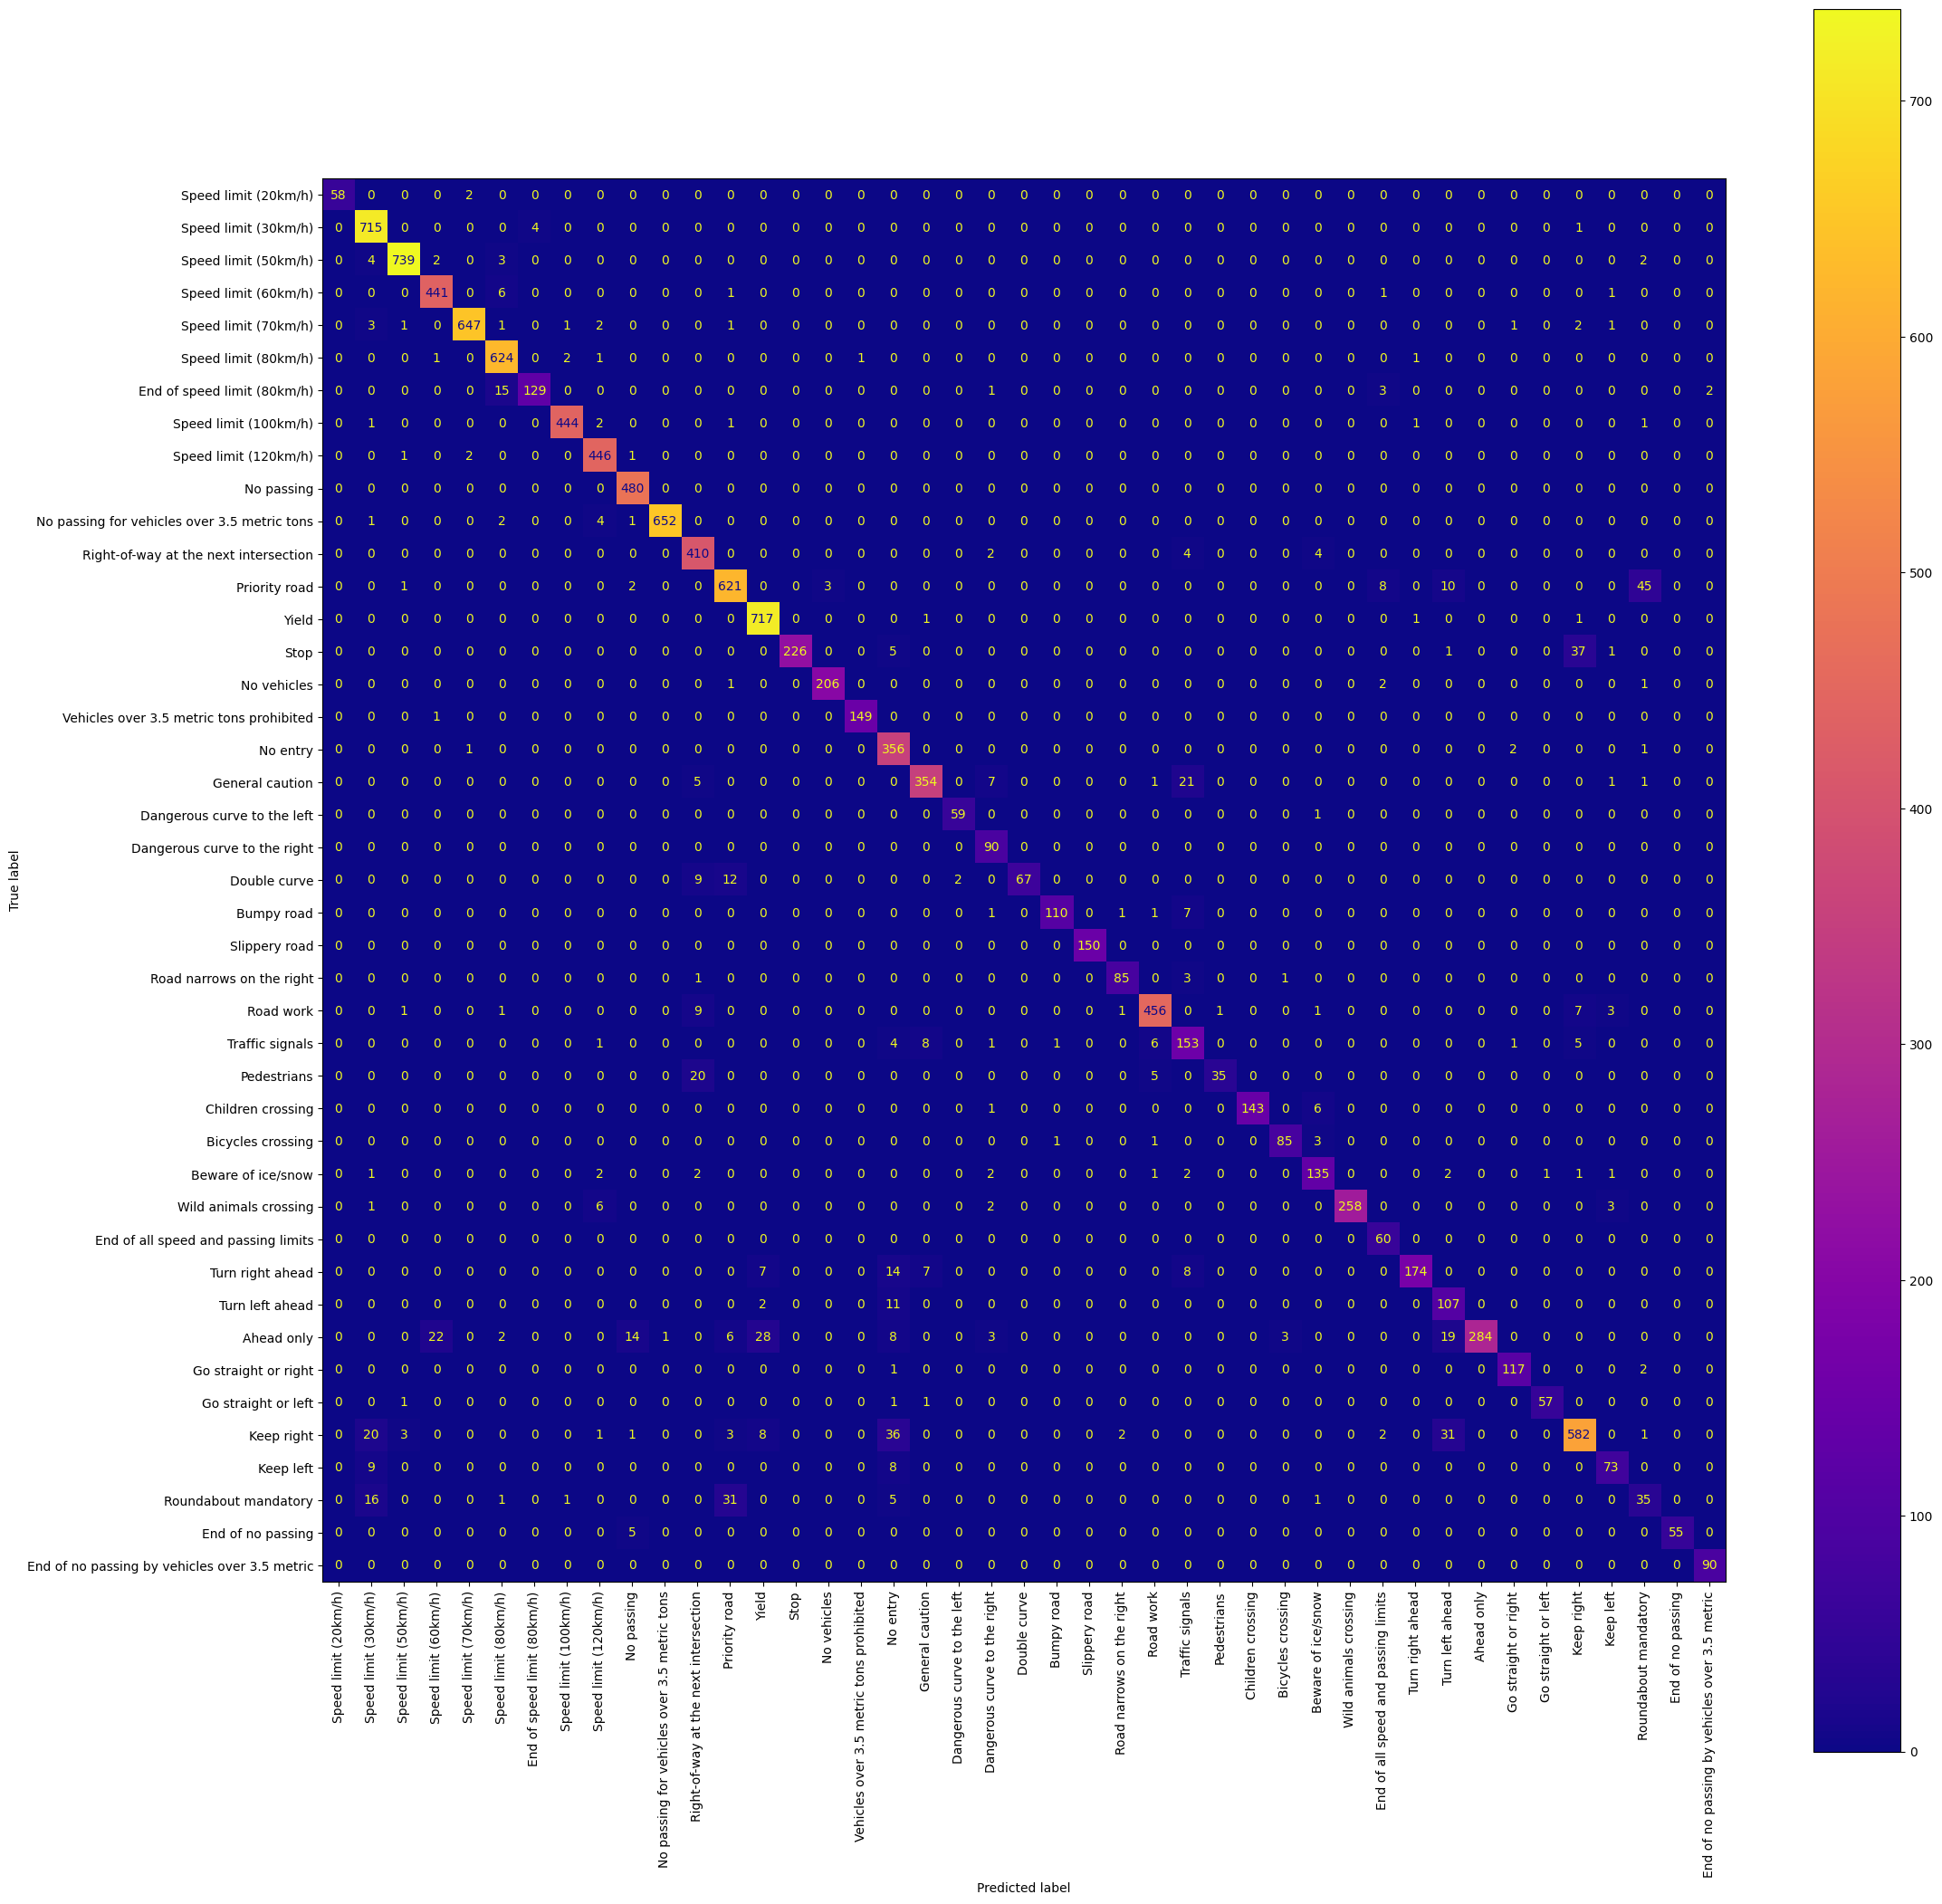

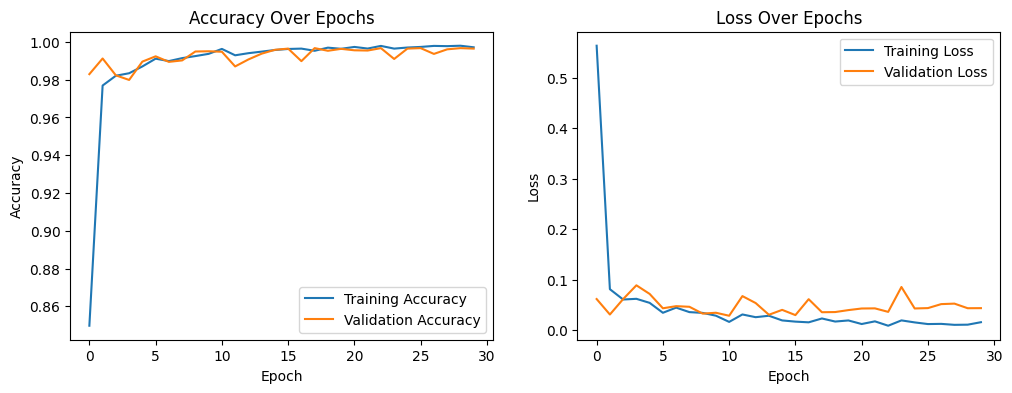

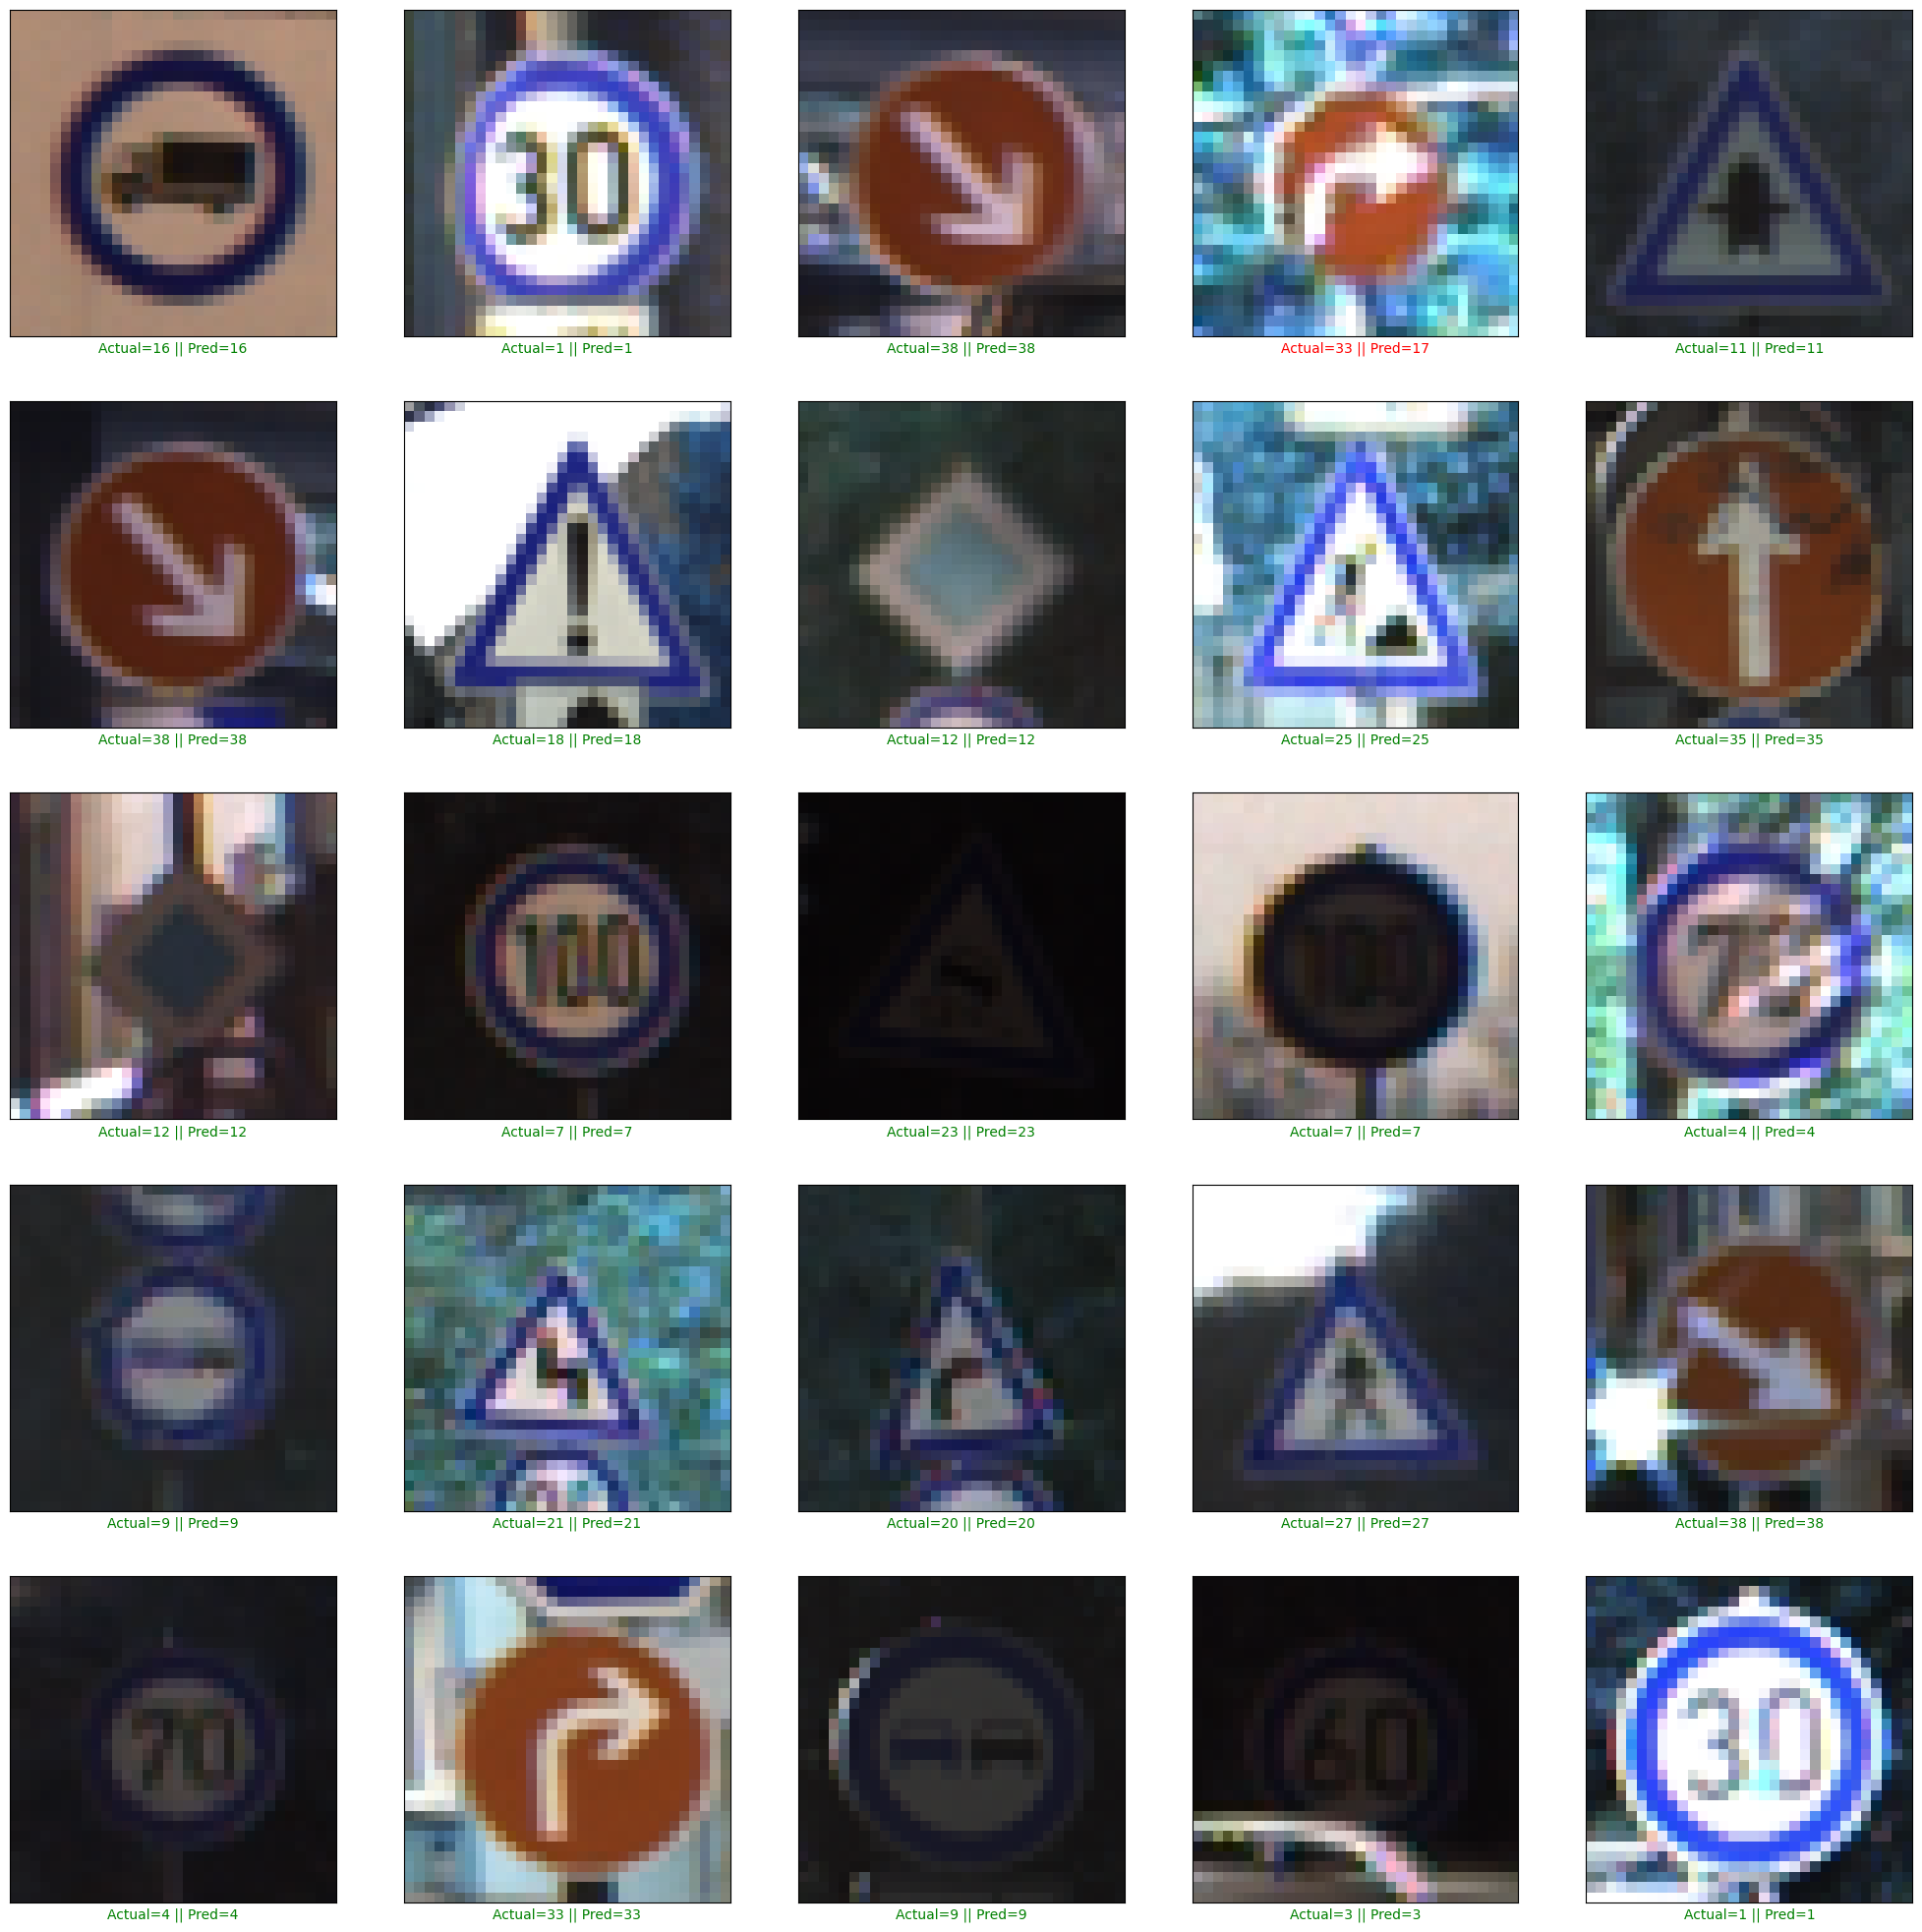

In [42]:
def evaluate_model_performance():

    y_pred = model.predict(x_test_images)
    y_pred = np.argmax(y_pred, axis=1)

    evaluation = accuracy_score(test_labels, y_pred)
    print(f'Test Accuracy : {evaluation * 100:.2f}%')

    print(classification_report(test_labels, y_pred))

    cm = confusion_matrix(test_labels, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(25, 25))
    disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='plasma')

    plt.show()

    #plot performance
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    plt.figure(figsize = (25, 25))
    start_index = 0
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        prediction = y_pred[start_index + i]
        actual = test_labels[start_index + i]
        col = 'g'
        if prediction != actual:
            col = 'r'
        plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
        plt.imshow(x_test_images[i])
    plt.show()

evaluate_model_performance()

# Save model
model.save('traffic_sign_detector6.h5')